## Step 0: Installing Libaries

In [ ]:
#NS Flash assignment 1

# Data cleanup

%pip install pandas networkx matplotlib seaborn numpy scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 1: Load and clean White Helmet data

In [ ]:
df = pd.read_csv(r'pairwise_52seconds_share.csv')
print(df.head())
print(df.info())

   Unnamed: 0      videoID                  userID_1  \
0           0  -6bGXfM8-gs  19372991|840224732847833   
1          10  -fJbMWhkTAw    Ej8Mm0YMadzmx4osDA_hgg   
2          11  -ilNuSh1Fgw    feNNP607aG1F64jR6bk8jw   
3          12  -ilNuSh1Fgw    5SDVRa-J-_cWYP6g0WNzLw   
4          13  -ilNuSh1Fgw    42Egn_22OjOzg2XMqAa9_g   

                   userID_2          timestamp_1          timestamp_2  \
0  19372991|840224732847833  2018-07-22 21:19:58  2018-07-22 21:19:58   
1    Ej8Mm0YMadzmx4osDA_hgg  2018-08-01 00:51:08  2018-08-01 00:51:08   
2    CVEf5dB1MvNRTQFYivAIPQ  2018-04-27 22:28:49  2018-04-27 22:29:36   
3    jz6hyweGgVHGTw-PbEMqKw  2018-05-14 16:52:08  2018-05-14 16:52:24   
4    poH0yvIGbS5_7MdXM4EuRA  2018-05-14 16:55:04  2018-05-14 16:55:15   

   time_diff_seconds  
0                0.0  
1                0.0  
2               47.0  
3               16.0  
4               11.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4471 entries, 0 to 4470
Data columns

In [ ]:
# Check for missing values
print("\nMissing Values per column")
print(df.isnull().sum())

# Check for duplicate rows
print(f"\nDuplicate Rows: {df.duplicated().sum()}")

# --- INVALID VALUES CHECKS ---

# 1. Time difference too large or negative
invalid_time_diff = df[(df['time_diff_seconds'] < 0.0) | (df['time_diff_seconds'] > 52.0)]
print(f"\nRows with invalid time differences: {len(invalid_time_diff)}")

# 2. Self-edges (user connected to itself)
same_user = df[df['userID_1'] == df['userID_2']]
print(f"Rows that connect edge to itself: {len(same_user)}")

# Remove self-edges
df = df[df['userID_1'] != df['userID_2']]
print(f"Remaining rows after removing self-edges: {len(df)}")

# 3. Edges with zero time difference (optional cleanup)
zero_time_diff = df[df['time_diff_seconds'] == 0.0]
print(f"Number of edges where time_diff_seconds is 0.0: {len(zero_time_diff)}")

# Show details for review
if len(zero_time_diff) > 0:
    print(zero_time_diff.head())

# Final dataframe info
print("\nDataFrame info after cleanup:")
print(df.info())



Missing Values per column
Unnamed: 0           0
videoID              0
userID_1             0
userID_2             0
timestamp_1          0
timestamp_2          0
time_diff_seconds    0
dtype: int64

Duplicate Rows: 0

Rows with invalid time differences: 0
Rows that connect edge to itself: 344
Remaining rows after removing self-edges: 4127
Number of edges where time_diff_seconds is 0.0: 14
      Unnamed: 0      videoID                   userID_1  \
161          260  2Jb_lpdNRU8    2572694|885420584986830   
206          310  3tIupmpY7IA  16548407|1821040977916389   
482          698  9gXHcOIhB7s     r73dGcK2Gcx8t6UNE1dRHA   
2501        2731  CLRsB_QJvkI     PMyrVtWQnGWB0QwsKS_NGw   
3486        3878  OCrY6Q_qZUY    318216|2356029011082368   

                    userID_2          timestamp_1          timestamp_2  \
161   3QOONeDucvajwi1U1Y5Z7A  2018-08-01 03:00:00  2018-08-01 03:00:00   
206   LEb7CblKLJHjHCnmytR5UQ  2018-04-19 08:15:14  2018-04-19 08:15:14   
482   GioWuAM9ufsQlV_-

## Step 2: Build graphs for White Helmtes data 
### (User1 -> User2, VideoID -> User1, VideoID -> User2)

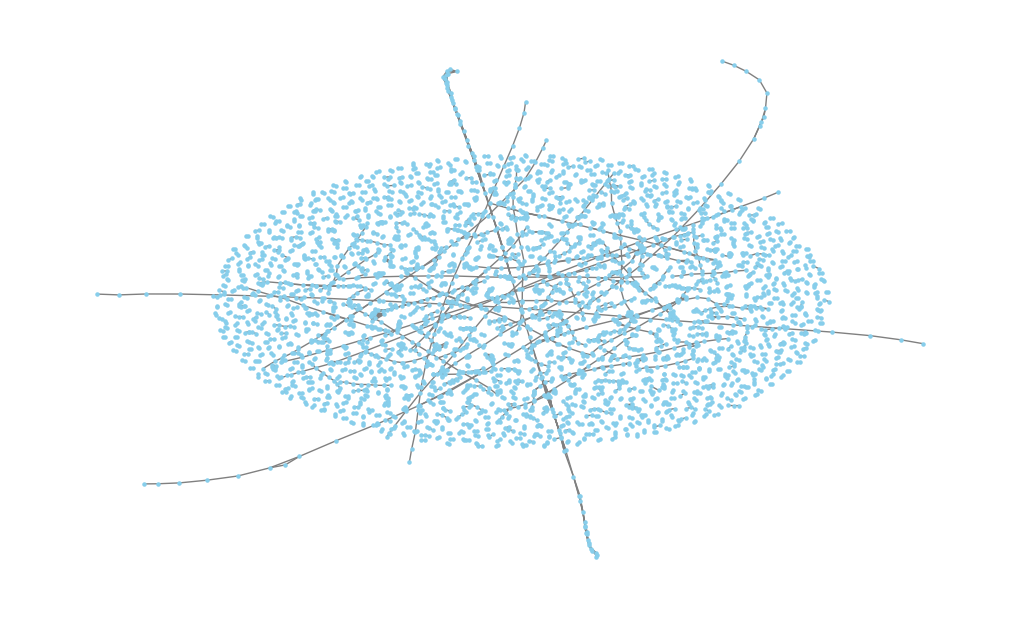

In [22]:
# Build User-User Graph

User_graph = nx.Graph()
User_graph = nx.from_pandas_edgelist( # Creating an edgelist from the dataframe
    df,
    source='userID_1', # Undirected network. Edges between users
    target='userID_2',
    edge_attr=['videoID', 'time_diff_seconds'],
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(User_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()

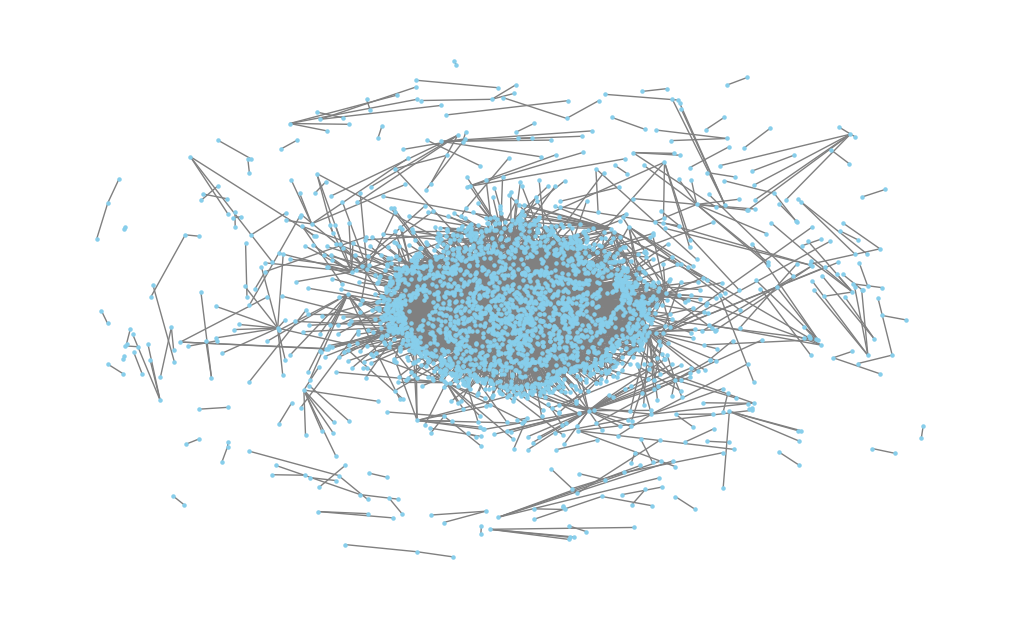

In [34]:
# Build VideoID-User1 Graph
edge_weights = df.groupby(['videoID', 'userID_1']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User1_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_1',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User1_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()


In [ ]:
# Build VideoID–User1 bipartite graph
edge_weights = df.groupby(['videoID', 'userID_1']).size().reset_index(name='weight')

# Create an empty graph
VideoID_User1_graph = nx.Graph()

# Add nodes for both partitions explicitly
VideoID_User1_graph.add_nodes_from(edge_weights['videoID'], bipartite=0)   # Partition 0: Videos
VideoID_User1_graph.add_nodes_from(edge_weights['userID_1'], bipartite=1)  # Partition 1: Users

# Add weighted edges between the partitions
for _, row in edge_weights.iterrows():
    VideoID_User1_graph.add_edge(row['videoID'], row['userID_1'], weight=row['weight'])

# --- Optional: Verify bipartite structure ---
is_bipartite = bipartite.is_bipartite(VideoID_User1_graph)
print(f"Is bipartite: {is_bipartite}")

# --- Draw bipartite graph ---
# Get the node sets (helps position the two groups separately)
video_nodes = set(n for n, d in VideoID_User1_graph.nodes(data=True) if d['bipartite'] == 0)
user_nodes = set(VideoID_User1_graph) - video_nodes

# Define positions: one group left, one right
pos = {}
pos.update((n, (1, i)) for i, n in enumerate(video_nodes))
pos.update((n, (2, i)) for i, n in enumerate(user_nodes))

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User1_graph, pos=pos, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.title("Bipartite Graph: VideoID–User1")
plt.show()


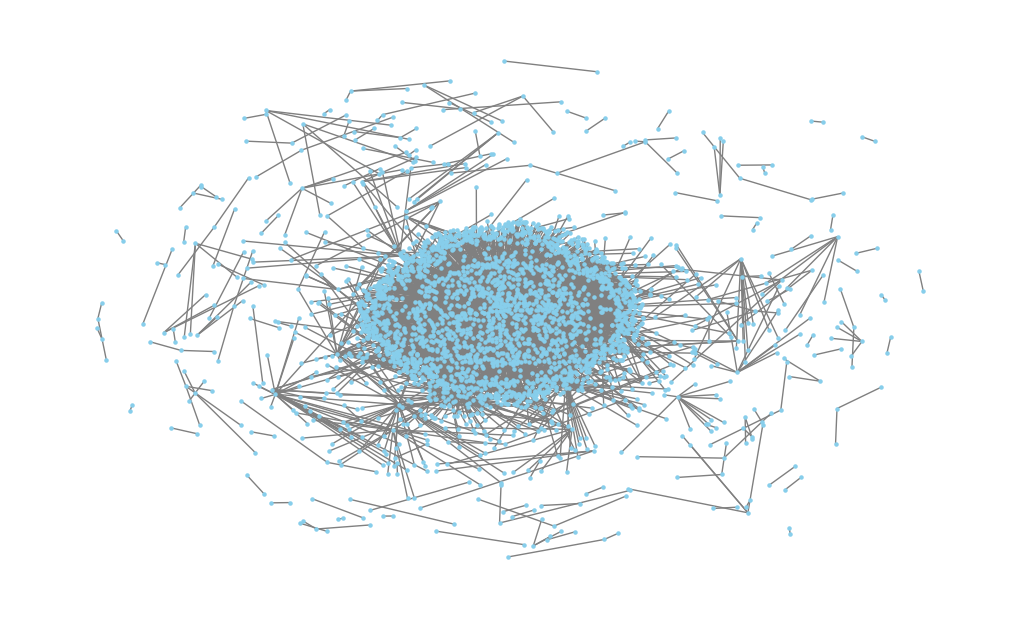

In [31]:
# Build VideoID-User2 Graph
edge_weights = df.groupby(['videoID', 'userID_2']).size().reset_index(name='weight')

# Create the graph with the 'weight' attribute
VideoID_User2_graph = nx.from_pandas_edgelist(
    edge_weights,
    source='videoID',
    target='userID_2',
    edge_attr='weight',
    create_using=nx.Graph()
)

plt.figure(figsize=(10, 6))
nx.draw(VideoID_User2_graph, with_labels=False, node_color='skyblue', edge_color='gray', node_size=5)
plt.show()


## Step 3: Get Networks Measures

#### 1. Average Degree

In [ ]:
def average_degree(G):
    return sum(dict(G.degree()).values()) / G.number_of_nodes()

avg_degree_User1 = average_degree(VideoID_User1_graph)
avg_degree_User2 = average_degree(VideoID_User2_graph)
avg_degree_UserGraph = average_degree(User_graph)

print("Average degree:")
print(f"VideoID–User1 Graph: {avg_degree_User1:.4f}")
print(f"VideoID–User2 Graph: {avg_degree_User2:.4f}")
print(f"User1–User2 Graph:  {avg_degree_UserGraph:.4f}")


Average degree:
VideoID–User1 Graph: 1.8905
VideoID–User2 Graph: 1.8905
User1–User2 Graph:  2.0238


The average degree is a good indicator of how many interactions a node has. It might be skewed by hubs, but it is still useful to avoid under- or overestimating the rate of interactions in the network. It is especially suitable here, as we generate networks with a similar number of nodes to recreate the White Helmet data set.

### 2. Density

In [ ]:
density_User1 = nx.density(VideoID_User1_graph)
density_User2 = nx.density(VideoID_User2_graph)
density_UserGraph = nx.density(User_graph)

print("Density:")
print(f"VideoID–User1 Graph: {density_User1:.4f}")
print(f"VideoID–User2 Graph: {density_User2:.4f}")
print(f"User1–User2 Graph:  {density_UserGraph:.4f}")


Justification:
The density measure is normalized between 0 and 1, which makes it ideal between different networks. It gives an indicator of how sparse or dense a network is. If the values of density for the networks differ drastically, the rate of interaction in these networks will probably very different. Generating a network with a similar density to the White Helmet data set, would create a realstic amount of interaction between nodes compared to the number of nodes.

### 3. Average Clustering Coefficient

In [46]:
avg_clustering_User1 = nx.average_clustering(VideoID_User1_graph)
avg_clustering_User2 = nx.average_clustering(VideoID_User2_graph)
avg_clustering_UserGraph = nx.average_clustering(User_graph)

print("Average clustering coefficient:")
print(f"VideoID–User1 Graph: {avg_clustering_User1:.4f}")
print(f"VideoID–User2 Graph: {avg_clustering_User2:.4f}")
print(f"User1–User2 Graph:  {avg_clustering_UserGraph:.4f}")


Average clustering coefficient:
VideoID–User1 Graph: 0.0000
VideoID–User2 Graph: 0.0000
User1–User2 Graph:  0.2998


Justification

### 4. Average Betweenes Centrality

In [49]:
bet_cent_User1 = nx.betweenness_centrality(VideoID_User1_graph)
bet_cent_User2 = nx.betweenness_centrality(VideoID_User2_graph)
bet_cent_UserGraph = nx.betweenness_centrality(User_graph)

avg_betweenness_User1 = sum(bet_cent_User1.values()) / len(bet_cent_User1)
avg_betweenness_User2 = sum(bet_cent_User2.values()) / len(bet_cent_User2)
avg_betweenness_UserGraph = sum(bet_cent_UserGraph.values()) / len(bet_cent_UserGraph)

print("Average betweenness centrality:")
print(f"VideoID–User1 Graph: {avg_betweenness_User1:.7f}")
print(f"VideoID–User2 Graph: {avg_betweenness_User2:.7f}")
print(f"User1–User2 Graph:  {avg_betweenness_UserGraph:.7f}")


Average betweenness centrality:
VideoID–User1 Graph: 0.0000683
VideoID–User2 Graph: 0.0000683
User1–User2 Graph:  0.0000014


Justification: Average Betweeness Centrality shows the importance of individual nodes in the network. It gives an idea of how centralized a network is. It is suitable for the task to understand if there are indivudal nodes which are important and central for the spread of information.

### 5. Average Degree Centrality

In [50]:
deg_cent_User1 = nx.degree_centrality(VideoID_User1_graph)
deg_cent_User2 = nx.degree_centrality(VideoID_User2_graph)
deg_cent_UserGraph = nx.degree_centrality(User_graph)

avg_deg_cent_User1 = sum(deg_cent_User1.values()) / len(deg_cent_User1)
avg_deg_cent_User2 = sum(deg_cent_User2.values()) / len(deg_cent_User2)
avg_deg_cent_UserGraph = sum(deg_cent_UserGraph.values()) / len(deg_cent_UserGraph)

print("Average degree centrality:")
print(f"VideoID–User1 Graph: {avg_deg_cent_User1:.6f}")
print(f"VideoID–User2 Graph: {avg_deg_cent_User2:.6f}")
print(f"User1–User2 Graph:  {avg_deg_cent_UserGraph:.6f}")


Average degree centrality:
VideoID–User1 Graph: 0.000613
VideoID–User2 Graph: 0.000613
User1–User2 Graph:  0.000502


Justification:

### 6. Average Shortest Path Length

In [51]:
def avg_shortest_path(G):
    if nx.is_connected(G):
        return nx.average_shortest_path_length(G)
    else:
        largest_component = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_component)
        return nx.average_shortest_path_length(subgraph)

avg_path_User1 = avg_shortest_path(VideoID_User1_graph)
avg_path_User2 = avg_shortest_path(VideoID_User2_graph)
avg_path_UserGraph = avg_shortest_path(User_graph)

print("Average shortest path length (LCC):")
print(f"VideoID–User1 Graph: {avg_path_User1:.4f}")
print(f"VideoID–User2 Graph: {avg_path_User2:.4f}")
print(f"User1–User2 Graph:  {avg_path_UserGraph:.4f}")


Average shortest path length (LCC):
VideoID–User1 Graph: 1.9985
VideoID–User2 Graph: 1.9985
User1–User2 Graph:  8.9026


Justification: The average shortest path length is good way to see how fast information can spread. Especially in the case of the White Helmet data set it is crucial to see how fast users can spread videos and therefore information to reach their goal. A shorter average shortest path indicates that information reaches the people very quickly and makes the network possibly very important.

### Step 4: Construct Watts Stogratz Graph

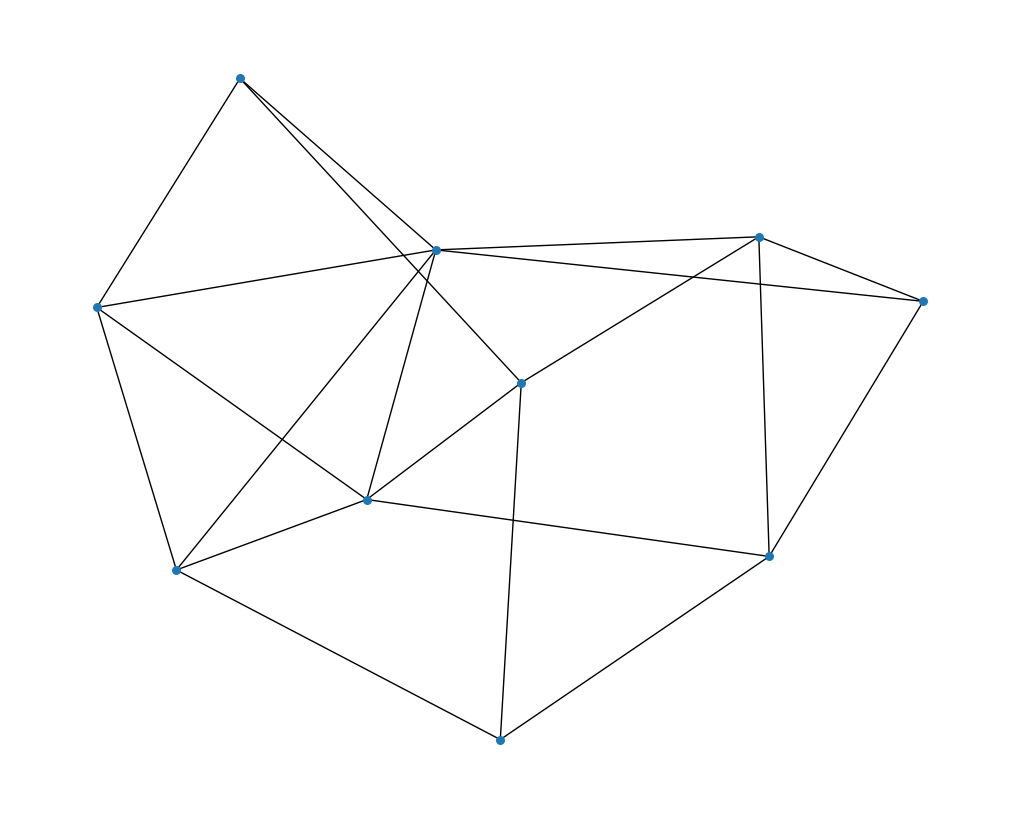

In [60]:
WS  = nx.watts_strogatz_graph(10, k=4, p=0.9, seed=None, create_using=None)
plt.figure(figsize=(10, 8))
nx.draw(WS, with_labels=False, node_size=30)
plt.show()

Justification: Watts Strogatz Graphs make it possible to generate graph with the same amount of nodes and a similar average degree compared to the White Helmet data set. These to attributes are very fundamental to a network and determine a lot of the shape of a network. Furthermore Watts Strogatz Graphs can recreate high clustering as it is seen in part of the White Helmet data set. Through the probability parameter the randomness of the network can be controlled. That makes this kind of graph very suitable to compare it against a real network to see if there are any inorganic patterns to be discovered.

In [ ]:
# Choose 5 Network Metrics from:

# Clustering Coefficient

# Average shortest path length?

# Connectivity?

# Density of the network 

# Betweenness Centrality

# Degrees Centrality

# (Load Centrality; Eigenvector centrality?)

# degree_assortativity_coefficient?

Generate Artificial Network - Watts-Strogatz (WS) graph

- Antoine


Generate Artificial Network - Barabási-Albert

- Daniel